In [1]:
import librosa as lib
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from IPython import display
import warnings
warnings.filterwarnings('ignore')

In [2]:
# I am using go,ma files for this assignment
# Making mfcc's with 25ms length and 10 ms overlap for file: filename
def make_input(file_name):
    l = []
    path ="./"+ file_name
    for i in os.listdir(path):
        if i.startswith(file_name):
            Path = os.path.join(path,i)
            wav,sr = lib.load(Path, duration=0.27, sr=None)
            mfccs = lib.feature.mfcc(y=wav, sr=sr, n_mfcc=13, hop_length=int(0.015*sr), n_fft=int(0.025*sr))
            l.append(mfccs.T)
    return l

In [3]:
# scaling_data 
def scaling_data(X):
    mean = np.mean(X,axis = 0)
    std = np.std(X,axis = 0)
    return (X-mean)/std

# scaling and getting train-test split using sklearn library
def get_train_test_samples(filename1,filename2):
    A_mfcc = make_input(filename1)
    B_mfcc = make_input(filename2)
    A_mfcc = scaling_data(np.array(A_mfcc))
    B_mfcc = scaling_data(np.array(B_mfcc))
    A_train,A_test = train_test_split(A_mfcc, test_size=0.2)
    B_train,B_test = train_test_split(B_mfcc, test_size=0.2)
    return A_train,A_test,B_train,B_test

# Data is ready
ma_train,ma_test,go_train,go_test = get_train_test_samples("ma","go")

In [4]:
# Normal Pdf
def normal(x,Mean,covar):
    N = x.shape[0]
    x,Mean = x.reshape(1,N),Mean.reshape(1,N)
    top=np.exp(-0.5*np.matmul(np.matmul(x-Mean,np.linalg.inv(covar)),(x-Mean).T))
    bot=np.sqrt(np.linalg.det(covar)*((2*np.pi)**N))
    return np.asscalar(top/bot)

# Function to run forward and backward pass to get alphas and betas
def alpha_beta(x,pis,weights,mean,covar,k):
    N = x.shape[0]
    alphas = []
    betas = []
    i=0
    c = np.zeros(N)  # For scaling(alpha,beta) purpose
    for i in range(N):
        probs = np.zeros((1,k))
        for j in range(k):
            probs[0][j] = normal(x[i],mean[j],covar[j])
        if(i==0): # for Base case
            temp = pis*probs
            c[i] = 1.0 / np.sum(temp)
            alphas.append(c[i] * temp)    
        else: # for remaining cases 
            temp = probs*np.matmul(alphas[-1],weights)
            c[i] = 1.0 / np.sum(temp)
            alphas.append(c[i] * temp)
    i = N-1
    while(i>=0):
        probs = np.zeros((k,1))
        for j in range(k):
            probs[j][0] = normal(x[i],mean[j],covar[j])
        if(i==N-1): # base case
            temp = np.ones((k,1))
            betas.append(temp)
        else: # for remaining cases 
            temp = np.matmul(weights,betas[-1]*probs)
            betas.append( temp * c[i])
        i=i-1
        
    # Converting all alphas and betas to arrays to make calculations ease
    alphas = np.array(alphas)
    betas = np.array(betas)
    betas = betas[::-1]
    lik = -np.sum(np.log(c)) # Our liklihood
    
#     print(lik)
    return alphas,betas,c,lik


# Function to find gamma
def gamma(alphas,betas,k):
    N = alphas.shape[0]
#     print(alpha.shape,beta.shape)
    gammas = np.zeros_like(alphas)
    for i in range(0,N):
        gammas[i] = ((alphas[i]*betas[i].reshape(1,k))/np.sum(alphas[-1]))
#     print(gammas.shape)
    return gammas

# Function to get epsilon
def epsilon(x,alphas,betas,co_efficents,mean,sigma,k):
    epsilons = np.zeros((alphas.shape[0],betas.shape[1],alphas.shape[2]))
    pis = np.zeros((1,k))
    for i in range(0,len(alphas)):
        prob = np.zeros((1,k))
        for j in range(0,k):
            prob[0][j] = normal(x[i],mean[j],sigma[j])
        epsilons[i] = np.matmul(np.matmul(co_efficents,alphas[i-1].T),(prob*betas[i].reshape(prob.shape)))/np.sum(alphas[-1])
#         print(epsilons[i].shape)
    return epsilons

In [5]:
# Expection step of EM-algo
def E_estimate_Parameters(X_train,Pi,A,mean,sigma,k):
    alphas,betas,c,lik = alpha_beta(X_train,Pi,A,mean,sigma,k)
#     print(c,c.shape)
    gammas = gamma(alphas,betas,k)
#     print(gamma.T)
#     print(np.log(l))
#     print(alpha.shape,beta.shape)
    epsilons = epsilon(X_train,alphas,betas,A,mean,sigma,k)
#     print(lik)
    return alphas,betas,gammas,epsilons,lik

# Maximization step
def M_update_Parameters(X_train,alphas,betas,gammas,epsilons,mean,k):
    N = alphas.shape[0]
    Pi_new = gammas[0]/np.sum(gammas[0])
    gammas=gammas.reshape(N,k)
    mean_new = np.matmul(X_train.T,gammas)/np.sum(gammas,axis=0)
    mean_new = mean_new.T
    A_new = np.sum(epsilons,axis=0)/np.sum(np.sum(epsilons,axis=0),axis=1)
#     print(A_new,alpha.shape)
#     print(epsilons.shape)
#     print(mean_new.shape)
#     print(Pi_new.shape)
    sigma_new=[]
    gamma_transpose = gammas.T
    for i in range(k):
        sigma_like = np.matmul((X_train-mean[i]).T,(X_train-mean[i]))
        sigma_temp = np.zeros(sigma_like.shape)
#         print(sigma_temp)
#         print(sigma_like.shape)
        for j in range(0,len(gamma_transpose[i])):
            sigma_temp += sigma_like*gamma_transpose[i][j]
        sigma_temp = sigma_temp/np.sum(gamma_transpose[i])
        sigma_new.append(sigma_temp)
    sigma_new = np.array(sigma_new)

    return Pi_new,A_new,sigma_new,mean_new,gammas

# Main HMM function: we can control num_iters here
def Hmm(X_train,k):
    N,m = X_train[0].shape
    # Initiliase: mean , sigma, A, Pi
    mean  = np.random.rand(k,m)
    C = []
    for i in range(k):
        C.append(np.identity(m))
    sigma = np.array(C)

    A = np.random.rand(k,k) 
    A_sum = np.sum(A,axis=1) # Upper trianglur initilization is not working well
    # for i in range(k):
    #     for j in range(k):
    #         if i < j :
    #             A[i][j] = 0
    for i in range(k):
        A[i,:] = A[i,:]/A_sum[i]

    Pi = np.random.rand(1,k)
    Pi = Pi/np.sum(Pi)
    
    # training
    count = 0
    likihoods = []
    while(count < 60) :
        Q = 0
        t_P=t_A=t_sigma=t_mean=0
        N = X_train.shape[0]
        for l in range(N):
            # E
            alphas,betas,gammas,epsilons,lik = E_estimate_Parameters(X_train[l],Pi,A,mean,sigma,k)
            # M
            Pi_new,A_new,sigma_new,mean_new,gammas = M_update_Parameters(X_train[l],alphas,betas,gammas,epsilons,mean,k)
            # U
            t_P += Pi_new
            t_A += A_new
            t_sigma += sigma_new
            t_mean += mean_new
            Q += lik
        Pi = t_P/N
        A = t_A/N
        sigma = t_sigma/N
        mean = t_mean/N
        Q = Q/N
        if count == 0: 
            count += 1
            continue
        display.clear_output(wait=True)
        print("[EPOCH]: %i, [LIKILIHOOD]: %.6f" % (count, Q))
        likihoods.append(Q)
        count+=1
        
    return Pi,A,mean,sigma,likihoods,count


### K = 3

[EPOCH]: 59, [LIKILIHOOD]: -577.772416


Text(0.5, 1.0, 'Likilihood')

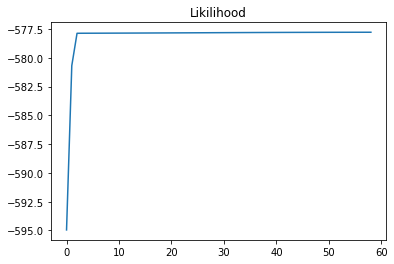

In [6]:
k = 3
pi_1,A_1,mean_1,sigma_1,l,num_iters = Hmm(ma_train,k)
likili = []
for i in range(0,len(l)):
    likili.append(l[i].item())
q = []
for i in range(num_iters-1):
    q.append(i)
plt.plot(q,likili)
plt.title("Likilihood")

[EPOCH]: 59, [LIKILIHOOD]: -572.278884


Text(0.5, 1.0, 'Likilihood')

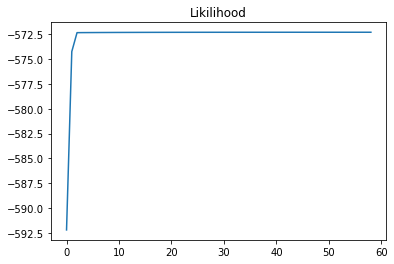

In [7]:
pi_2,A_2,mean_2,sigma_2,l,num_iters = Hmm(go_train,k)
likili = []
for i in range(0,len(l)):
    likili.append(l[i].item())
q = []
for i in range(num_iters-1):
    q.append(i)
plt.plot(q,likili)
plt.title("Likilihood")

In [8]:
N = ma_test.shape[0]
nums = 0
# for ma data
for i in range(N):
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(ma_test[i],pi_1,A_1,mean_1,sigma_1,k)
    Q1 = np.sum(alphas)
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(ma_test[i],pi_2,A_2,mean_2,sigma_2,k)
    Q2 = np.sum(alphas)
    if Q1 >= Q2:
        nums += 1
    
m = N
N = go_test.shape[0]
# for go data
for i in range(N):
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(go_test[i],pi_1,A_1,mean_1,sigma_1,k)
    Q1 = np.sum(alphas)
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(go_test[i],pi_2,A_2,mean_2,sigma_2,k)
    Q2 = np.sum(alphas)
    if Q1 <= Q2:
        nums += 1

m += N
print("Accuracy with k = 3: ", nums/m)

Accuracy with k = 3:  0.875


### K = 5

[EPOCH]: 59, [LIKILIHOOD]: -577.801005


Text(0.5, 1.0, 'Likilihood')

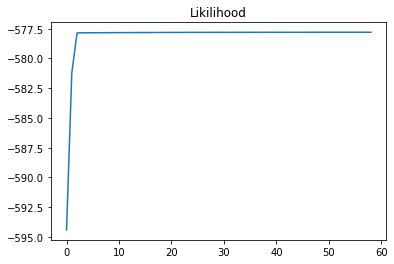

In [9]:
k = 5
pi_1,A_1,mean_1,sigma_1,l,num_iters = Hmm(ma_train,k)
likili = []
for i in range(0,len(l)):
    likili.append(l[i].item())
q = []
for i in range(num_iters-1):
    q.append(i)
plt.plot(q,likili)
plt.title("Likilihood")

[EPOCH]: 59, [LIKILIHOOD]: -572.270993


Text(0.5, 1.0, 'Likilihood')

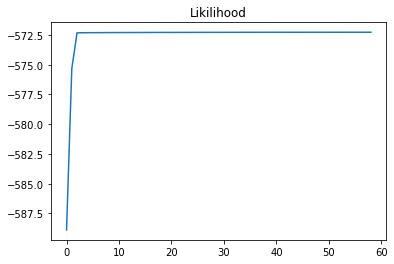

In [10]:
pi_2,A_2,mean_2,sigma_2,l,num_iters = Hmm(go_train,k)
likili = []
for i in range(0,len(l)):
    likili.append(l[i].item())
q = []
for i in range(num_iters-1):
    q.append(i)
plt.plot(q,likili)
plt.title("Likilihood")

In [11]:
N = ma_test.shape[0]
nums = 0
# for ma data
for i in range(N):
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(ma_test[i],pi_1,A_1,mean_1,sigma_1,k)
    Q1 = np.sum(alphas)
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(ma_test[i],pi_2,A_2,mean_2,sigma_2,k)
    Q2 = np.sum(alphas)
    if Q1 >= Q2:
        nums += 1
    
m = N
N = go_test.shape[0]
# for go data
for i in range(N):
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(go_test[i],pi_1,A_1,mean_1,sigma_1,k)
    Q1 = np.sum(alphas)
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(go_test[i],pi_2,A_2,mean_2,sigma_2,k)
    Q2 = np.sum(alphas)
    if Q1 <= Q2:
        nums += 1

m += N
print("Accuracy with k = 5: ", nums/m)

Accuracy with k = 5:  0.75


### K = 7

In [ ]:
k = 7
pi_1,A_1,mean_1,sigma_1,l,num_iters = Hmm(ma_train,k)
likili = []
for i in range(0,len(l)):
    likili.append(l[i].item())
q = []
for i in range(num_iters-1):
    q.append(i)
plt.plot(q,likili)
plt.title("Likilihood")

[EPOCH]: 40, [LIKILIHOOD]: -577.695077


In [ ]:
pi_2,A_2,mean_2,sigma_2,l,num_iters = Hmm(go_train,k)
likili = []
for i in range(0,len(l)):
    likili.append(l[i].item())
q = []
for i in range(num_iters-1):
    q.append(i)
plt.plot(q,likili)
plt.title("Likilihood")

In [ ]:
N = ma_test.shape[0]
nums = 0
# for ma data
for i in range(N):
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(ma_test[i],pi_1,A_1,mean_1,sigma_1,k)
    Q1 = np.sum(alphas)
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(ma_test[i],pi_2,A_2,mean_2,sigma_2,k)
    Q2 = np.sum(alphas)
    if Q1 >= Q2:
        nums += 1
    
m = N
N = go_test.shape[0]
# for go data
for i in range(N):
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(go_test[i],pi_1,A_1,mean_1,sigma_1,k)
    Q1 = np.sum(alphas)
    alphas,betas,gammas,epsilons,probs_ma = E_estimate_Parameters(go_test[i],pi_2,A_2,mean_2,sigma_2,k)
    Q2 = np.sum(alphas)
    if Q1 <= Q2:
        nums += 1

m += N
print("Accuracy with k = 7: ", nums/m)

## Report

Note_1: I think because of random initilization my accuracies are differing but if after running for more times(i noted for almost 20 times with different random initilization),I am coming to this conclusion. And i am training for 50 iterations only

1) In most cases my accuracy increased with k,but in few some other accuaracy decreased with k. <br>
2) I can't say increasing or decreasing but most of the times i got best accuaracy by k = 3,k = 7.On average k = 7 is best as sometimes k = 3 accuracy is decreasing.Where as k = 5 accuracy is always between accuraices of  k = 3 and k = 7. <br>

MY avg Findings: <br>
with k = 3: 0.65-0.82 <br>
with k = 5: 0.62-0.85 <br>
with k = 7: 0.65-0.86 <br>

3) I feel like  k = 7 or k = 3 is best Option for this problem .It gave most stable results.From these two better to choose k = 3 as it has lesser parameters.<br>